In [1]:
#Eh, new dataset new notebook.... let's do this:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error

from datetime import datetime
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# pip install pmdarima

In [4]:
# import warnings #Idea from Ben Moss of our GA cohort - thank you! Just to make tuning easier on our eyes...
# warnings.simplefilter(action='ignore', category=[FutureWarning, Warning, UserWarning];
from pmdarima import auto_arima

In [5]:
df = pd.read_csv('../data..final_dataset.csv')
print(df.shape)
# df = df.drop(columns=['Unnamed: 0'], axis = 1)
df

(247, 69)


,Unnamed: 0,date,year,month,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,...,cc_bals_90d_due_percentage,Mortgage_servicing,cc_payments,cc_payments_yoy,Mortgage_servicing_yoy,cc_bals_30d_due_percentage_yoy,cc_bals_90d_due_percentage_yoy,cc_bals_30d_due_percentage_yoy_3m,cc_bals_30d_due_percentage_yoy_6m,cc_bals_30d_due_percentage_6m
0,0,2003-01-01,2003,January,289412000.0,5.8,NaN,2.597403,3.120429,14.145031,...,NaN,29.236872,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
1,1,2003-02-01,2003,February,289606000.0,5.9,NaN,2.980877,2.718447,21.981982,...,NaN,29.679900,8.49618,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
2,2,2003-03-01,2003,March,289809000.0,5.9,NaN,3.020134,2.520601,23.356401,...,NaN,29.184600,8.46384,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
3,3,2003-04-01,2003,April,290024000.0,6.0,NaN,2.224694,2.222222,13.011457,...,NaN,29.527500,8.43150,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
4,4,2003-05-01,2003,May,290250000.0,6.1,NaN,2.057842,2.507232,9.031733,...,NaN,28.423572,8.39916,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,242,2023-03-01,2023,March,334664000.0,3.5,4.616834,4.984974,8.175182,-6.424898,...,1.330000,78.619616,20.97054,60.285403,65.492112,51.559633,26.605505,50.328947,NaN,NaN
243,243,2023-04-01,2023,April,334792000.0,3.4,4.663537,4.930320,8.095818,-5.064848,...,1.320000,76.198795,21.22829,60.191989,34.304782,53.333333,27.222222,49.065421,NaN,NaN
244,244,2023-05-01,2023,May,334929000.0,3.7,4.551122,4.047609,8.026785,-11.663368,...,1.386667,77.999500,22.48636,60.671371,27.807544,51.742160,26.829268,NaN,NaN,NaN
245,245,2023-06-01,2023,June,335080000.0,3.6,4.658385,2.969178,7.798839,-16.738092,...,1.453333,81.507960,22.48636,56.734870,26.494016,50.328947,26.480263,NaN,NaN,NaN


In [6]:
# #Delayed until later to make things a bit easier.
# df.set_index('date', inplace=True)
# df.sort_index(inplace=True)

In [7]:
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['Unnamed:_0', 'date', 'year', 'month', 'population',
       'unemployment_rate', 'hourly_earnings_yoy', 'cpi_yoy', 'shelter_yoy',
       'energy_yoy', 'medical_care_yoy', 'food_yoy', 'gasoline_yoy',
       'imports_yoy', 'new_&_used_vehicles_yoy', 'all_less_food_&_shelter_yoy',
       'total_personal_income', 'total_employee_compensation',
       'wages_and_salaries_all', 'wages_salaries_private_employees',
       'wages_salaries_government_employees',
       'employer_contributions_for_employee_pension_and_insurance_funds',
       'employer_contributions_for_government_social_insurance',
       'rental_income_(capital_consumption_adjusted)',
       'personal_dividend_income', 'personal_interest_income',
       'total_gov_social_benefits', 'social_security', 'medicare', 'medicaid',
       'unemployment_insurance', 'veterans'_benefits',
       'total_disposible_personal_income_chained_2017',
       'total_personal_savings',
       'personal_saving_as_a_percentage_of_disposable_pe

In [8]:
dubious = list(df.columns[df.columns.str.contains("cc")])
dubious.remove('cc_bals_30d_due_percentage')
dubious.remove('cc_bals_90d_due_percentage')
dubious.append('year')
dubious.append('month')
dubious.append('Qtr')

In [9]:
focus = df.drop(columns=dubious, axis=1)
focus = focus[focus['cc_bals_30d_due_percentage'].notnull()]
print(focus.shape)
focus #Oye..... this is bad
#This data was supposed to just be quarterly.... 

(133, 55)


,Unnamed:_0,date,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
114,114,2012-07-01,314796000.0,8.2,1.731602,1.408451,2.112106,-5.022144,4.110711,2.327476,...,4.583906,8.028,0.573,0.768,0.674,0.956,0.311,11.310,28.499400,-25.369019
115,115,2012-08-01,315031000.0,8.1,1.777200,1.692379,2.107566,-0.556204,4.028033,2.004757,...,5.518289,8.033,0.563,0.783,0.679,0.966,0.317,11.341,28.934866,-18.041664
116,116,2012-09-01,315264000.0,7.8,1.946367,1.991282,2.202495,2.336314,4.040507,1.615540,...,5.487353,8.033,0.563,0.783,0.679,0.966,0.317,11.341,28.095417,-17.240839
117,117,2012-10-01,315485000.0,7.8,1.551724,2.162344,2.224469,3.993740,3.712741,1.671306,...,5.835689,8.033,0.563,0.783,0.679,0.966,0.317,11.341,27.171623,-19.204431
118,118,2012-11-01,315692000.0,7.7,1.897370,1.764134,2.206854,0.322869,3.390749,1.779107,...,5.709178,7.932,0.552,0.794,0.660,0.986,0.307,11.231,26.588064,-18.657597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,242,2023-03-01,334664000.0,3.5,4.616834,4.984974,8.175182,-6.424898,1.495750,8.499364,...,6.762653,12.014,0.340,1.582,1.031,1.569,0.527,17.063,78.619616,65.492112
243,243,2023-04-01,334792000.0,3.4,4.663537,4.930320,8.095818,-5.064848,1.053688,7.651208,...,6.414150,12.014,0.340,1.582,1.031,1.569,0.527,17.063,76.198795,34.304782
244,244,2023-05-01,334929000.0,3.7,4.551122,4.047609,8.026785,-11.663368,0.724042,6.691542,...,5.762839,12.140,0.349,1.595,1.079,1.599,0.529,17.291,77.999500,27.807544
245,245,2023-06-01,335080000.0,3.6,4.658385,2.969178,7.798839,-16.738092,0.131165,5.741851,...,5.254929,12.140,0.349,1.595,1.079,1.599,0.529,17.291,81.507960,26.494016


In [10]:
#I was told by another group member that he interpolated.... I didn'tknow he overrid the originals.... gah
#We'll use the original 'index' to do this...

#If this wouldn't be our target then mabye, but when it is....
focus = focus[focus['Unnamed:_0']%3==0]
focus = focus.drop(columns=['Unnamed:_0'], axis=1)
print(focus.shape)
focus.head()

(45, 54)


,date,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
114,2012-07-01,314796000.0,8.2,1.731602,1.408451,2.112106,-5.022144,4.110711,2.327476,-5.555556,...,4.583906,8.028,0.573,0.768,0.674,0.956,0.311,11.310,28.499400,-25.369019
117,2012-10-01,315485000.0,7.8,1.551724,2.162344,2.224469,3.993740,3.712741,1.671306,9.169550,...,5.835689,8.033,0.563,0.783,0.679,0.966,0.317,11.341,27.171623,-19.204431
120,2013-01-01,316038000.0,8.0,2.150538,1.594865,2.212076,-0.978298,3.114639,1.579517,-1.412180,...,5.791267,7.932,0.552,0.794,0.660,0.986,0.307,11.231,27.079848,-15.513044
123,2013-04-01,316535000.0,7.6,2.052159,1.063085,2.196004,-4.293099,2.806975,1.546516,-8.581614,...,6.128141,7.841,0.540,0.814,0.668,0.994,0.296,11.153,27.012245,-15.201883
126,2013-07-01,317156000.0,7.3,2.042553,1.960682,2.366684,4.749721,1.919406,1.442880,5.128948,...,6.232383,7.897,0.535,0.845,0.672,1.027,0.304,11.280,34.509890,21.089883


In [11]:
focus.tail(4)

,date,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
237,2022-10-01,334071000.0,3.6,4.975923,7.745427,6.903758,17.631923,5.003761,10.949139,18.641064,...,7.748737,11.923,0.336,1.552,0.986,1.595,0.507,16.899,82.268700,145.374768
240,2023-01-01,334433000.0,3.4,4.552640,6.410147,7.906914,8.700073,3.060229,10.133484,1.142690,...,7.697741,12.044,0.339,1.562,0.986,1.604,0.512,17.047,75.545990,96.146420
243,2023-04-01,334792000.0,3.4,4.663537,4.930320,8.095818,-5.064848,1.053688,7.651208,-12.549754,...,6.414150,12.014,0.340,1.582,1.031,1.569,0.527,17.063,76.198795,34.304782
246,2023-07-01,335248000.0,3.5,4.670585,3.177780,7.658308,-12.470230,-0.520244,4.858815,-20.034283,...,4.910374,12.140,0.349,1.595,1.079,1.599,0.529,17.291,83.037600,31.475018


In [12]:
val_dates = pd.DataFrame(data={'date':['2023-10-01','2024-01-01','2024-04-01','2024-07-01']})
val_dates

,date
0,2023-10-01
1,2024-01-01
2,2024-04-01
3,2024-07-01


In [13]:
proper_focus = pd.concat([focus, val_dates])
proper_focus.tail()

,date,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
246,2023-07-01,335248000.0,3.5,4.670585,3.17778,7.658308,-12.47023,-0.520244,4.858815,-20.034283,...,4.910374,12.14,0.349,1.595,1.079,1.599,0.529,17.291,83.0376,31.475018
0,2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
proper_focus.set_index('date', inplace=True)
proper_focus.sort_index(inplace=True)
print(proper_focus.shape)
proper_focus.tail()

(49, 53)


,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
date,,,,,,,,,,,,,,,,,,,,,
2023-07-01,335248000.0,3.5,4.670585,3.17778,7.658308,-12.47023,-0.520244,4.858815,-20.034283,-4.781421,...,4.910374,12.14,0.349,1.595,1.079,1.599,0.529,17.291,83.0376,31.475018
2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
X = proper_focus.drop(columns=['cc_bals_30d_due_percentage', 'cc_bals_90d_due_percentage'], axis=1)
y_30 = proper_focus['cc_bals_30d_due_percentage']#we'll start with this one
y_90 = proper_focus['cc_bals_90d_due_percentage']

#We know from previous workbooks that the guys are already significant as are, so per them no need to diff.

In [16]:
y_30_tt = y_30[4:len(y_30)-4]
y_90_tt = y_90[4:len(y_90)-4]
y_val = y_30[-4:] #Works for both of them, as we really just need their dates... Technically superfluos, but nicer this way
#than to ref. it via x_val (which we never even ended up using)
y_val
# y_90_tt

date
2023-10-01   NaN
2024-01-01   NaN
2024-04-01   NaN
2024-07-01   NaN
Name: cc_bals_30d_due_percentage, dtype: float64

In [17]:
X_shift = X.shift(4) #As we'll be projecting 4 periods into the future...
X_shift.tail()

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
date,,,,,,,,,,,,,,,,,,,,,
2023-07-01,333599000.0,3.5,5.481240,8.524815,5.719398,32.927696,4.816848,10.932056,44.355088,8.766716,...,7.192072,11.669,0.322,1.524,0.925,1.574,0.491,16.505,63.158462,106.351004
2023-10-01,334071000.0,3.6,4.975923,7.745427,6.903758,17.631923,5.003761,10.949139,18.641064,4.236669,...,7.748737,11.923,0.336,1.552,0.986,1.595,0.507,16.899,82.268700,145.374768
2024-01-01,334433000.0,3.4,4.552640,6.410147,7.906914,8.700073,3.060229,10.133484,1.142690,0.856531,...,7.697741,12.044,0.339,1.562,0.986,1.604,0.512,17.047,75.545990,96.146420
2024-04-01,334792000.0,3.4,4.663537,4.930320,8.095818,-5.064848,1.053688,7.651208,-12.549754,-4.881356,...,6.414150,12.014,0.340,1.582,1.031,1.569,0.527,17.063,76.198795,34.304782
2024-07-01,335248000.0,3.5,4.670585,3.177780,7.658308,-12.470230,-0.520244,4.858815,-20.034283,-4.781421,...,4.910374,12.140,0.349,1.595,1.079,1.599,0.529,17.291,83.037600,31.475018


In [18]:
X_shift = X_shift.dropna()
print(X_shift.shape) #As we should expect, with the now shifted data... and recall that y is currently untouched
X_shift.head()

(45, 51)


,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,314796000.0,8.2,1.731602,1.408451,2.112106,-5.022144,4.110711,2.327476,-5.555556,-3.300562,...,4.583906,8.028,0.573,0.768,0.674,0.956,0.311,11.310,28.499400,-25.369019
2013-10-01,315485000.0,7.8,1.551724,2.162344,2.224469,3.993740,3.712741,1.671306,9.169550,0.000000,...,5.835689,8.033,0.563,0.783,0.679,0.966,0.317,11.341,27.171623,-19.204431
2014-01-01,316038000.0,8.0,2.150538,1.594865,2.212076,-0.978298,3.114639,1.579517,-1.412180,-1.476793,...,5.791267,7.932,0.552,0.794,0.660,0.986,0.307,11.231,27.079848,-15.513044
2014-04-01,316535000.0,7.6,2.052159,1.063085,2.196004,-4.293099,2.806975,1.546516,-8.581614,-2.706454,...,6.128141,7.841,0.540,0.814,0.668,0.994,0.296,11.153,27.012245,-15.201883
2014-07-01,317156000.0,7.3,2.042553,1.960682,2.366684,4.749721,1.919406,1.442880,5.128948,0.871460,...,6.232383,7.897,0.535,0.845,0.672,1.027,0.304,11.280,34.509890,21.089883


In [19]:
X_valid = X_shift.tail(4) #Got themsecured..
X_valid

,population,unemployment_rate,hourly_earnings_yoy,cpi_yoy,shelter_yoy,energy_yoy,medical_care_yoy,food_yoy,gasoline_yoy,imports_yoy,...,credit_yoy,Mortgage,HE_Revolving,Auto_Loan,Credit_Card,Student_Loan,Other,Total,Mortgage_servicing,Mortgage_servicing_yoy
date,,,,,,,,,,,,,,,,,,,,,
2023-10-01,334071000.0,3.6,4.975923,7.745427,6.903758,17.631923,5.003761,10.949139,18.641064,4.236669,...,7.748737,11.923,0.336,1.552,0.986,1.595,0.507,16.899,82.268700,145.374768
2024-01-01,334433000.0,3.4,4.552640,6.410147,7.906914,8.700073,3.060229,10.133484,1.142690,0.856531,...,7.697741,12.044,0.339,1.562,0.986,1.604,0.512,17.047,75.545990,96.146420
2024-04-01,334792000.0,3.4,4.663537,4.930320,8.095818,-5.064848,1.053688,7.651208,-12.549754,-4.881356,...,6.414150,12.014,0.340,1.582,1.031,1.569,0.527,17.063,76.198795,34.304782
2024-07-01,335248000.0,3.5,4.670585,3.177780,7.658308,-12.470230,-0.520244,4.858815,-20.034283,-4.781421,...,4.910374,12.140,0.349,1.595,1.079,1.599,0.529,17.291,83.037600,31.475018


In [20]:
X_shift.shape[0]

45

In [21]:
X_shift_tt = X_shift.iloc[0:(X_shift.shape[0]-4)]
print(X_shift_tt.shape)

(41, 51)


In [22]:
X_train, X_test, y_train_30, y_test_30 = train_test_split(X_shift_tt, y_30[4:len(y_30)-4], test_size=.1,
                                                    shuffle=False)
#X_train and test will bet he same....which we want
X_train, X_test, y_train_90, y_test_90 = train_test_split(X_shift_tt, y_90[4:len(y_30)-4], test_size=.1,
                                                    shuffle=False)

In [23]:
ss = StandardScaler() #Thanks to Ben Moss for confirming that the standard scaling is independnet from one feature to another.
#Albeit does change the train/test though.
X_train_fit = ss.fit_transform(X_train)
X_test_fit = ss.transform(X_test)
X_valid_fit = ss.transform(X_valid)

In [24]:
X_tt_fit = ss.fit_transform(X_shift_tt)

In [25]:
# # Starting MSE and (P, D, Q, S.
# best_aic = 100_000_000
# best_mape = 100_000_000
# best_aic_params, best_mape_params = [], []
# # final_p = final_d = final_q = 0
# # final_P = final_D = final_Q = final_S =0

# for p in range(0,2):
#     for d in range(0,2):
#         for q in range(2,4):
#             for P in range(0,2):
#                 for D in range(1,3):
#                     for Q in range(2,4):
#                         for S in range(3,5,1):
#                             try:
#                                 #print(f'Attempting to fit SARIMAX({p}, {d}, {q})x({P},{D},{Q},{S})')
#                     # Instantiate SARIMAX model.
#                                 sarimax = SARIMAX(endog = y_train_30,
#                                      order = (p, d, q),              # (p, d, q)
#                                      seasonal_order = (P, D, Q, S)  # (P, D, Q, S)
#                                      ) 
 
#                     # Fit SARIMAX model.
#                                 model = sarimax.fit()

#                     # Generate predictions based on test set.
#                                 preds = model.predict(start=datetime(2022,7,1),
#                                           end=datetime(2023,7,1)
#                                           )

#                     # Evaluate predictions.
#                                 if S == 6:
#                                     print(f'The AIC for ({p}, {d}, {q})x({P},{D},{Q},{S}) is: {model.aic}')#To at least get some gauge on 'progress'

#                     # Save for final report.
#                                 if best_aic > model.aic:
#                                     best_aic = model.aic
#                                     best_aic_params = [p,d,q,P,D,Q,S]
#                                 if best_mape > mean_absolute_percentage_error(y_test_30, preds):
#                                     best_mape = mean_absolute_percentage_error(y_test_30, preds)
#                                     best_mape_params = [p,d,q,P,D,Q,S]

#                             except:
#                                 pass

# print(f'The best model has an AIC of {best_aic} with parameters of {best_aic_params}.')
# print(f'The best model has an MAPE of {best_mape} with parameters of {best_mape_params}.')

-27.547783584178212


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


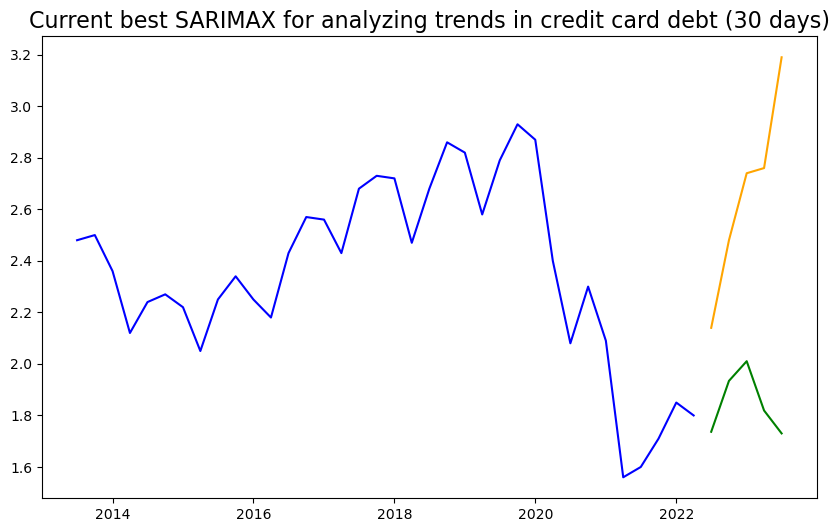

In [26]:
#Oooh, that really didn't take that long... likely since it was without exogenous variables. Anyways, let's see the bros:

#And gf m, messed up orders of d and q....SO JUST FOR THIS DEMO RUN will we see d and q differently...
    #Was tmpted to make a dictionary, but eh...
p = 2
d = 2
q = 1
P = 0
D = 0
Q = 0
S = 3

sarima = SARIMAX(endog=y_train_30,
                order=(p,q,d), seasonal_order=(P, D, Q, S),
                )


# Fit SARIMA model.
model = sarima.fit()
print(model.aic)
# Generate predictions based on test set.
preds = model.predict(start = datetime(2022,7,1), end=datetime(2023,7,1),
                     )

#Conversions, at least needed for this data.Thank you Eric!
y_train_notcontroversial, y_test_notcontroversial = y_train_30.copy(), y_test_30.copy()
y_train_notcontroversial.index = pd.to_datetime(y_train_30.index)
y_test_notcontroversial.index = pd.to_datetime(y_test_30.index)


# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train_notcontroversial, color = 'blue')
plt.plot(y_test_notcontroversial, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Current best SARIMAX for analyzing trends in credit card debt (30 days)', fontsize=16)
plt.show();

In [27]:
# y_train_30[0], y_30_tt[0]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was prov

0.0139128423957972


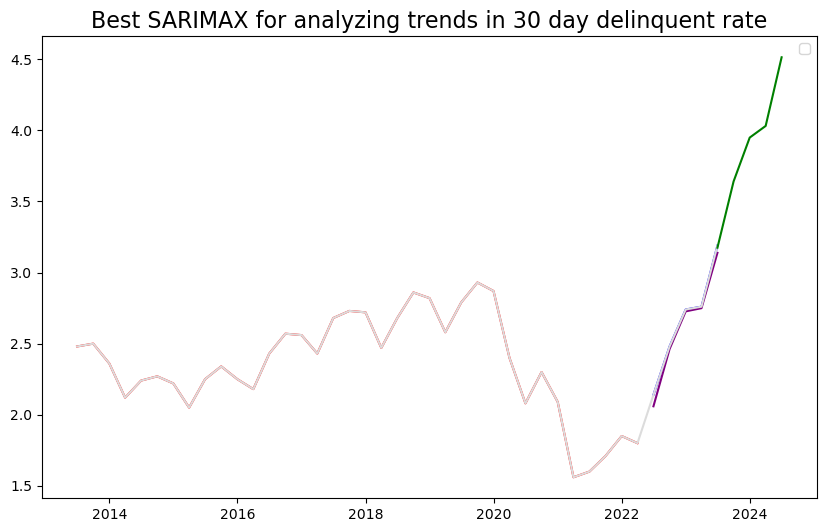

In [85]:
#Now for MAPE:
#Oooh, that really didn't take that long... likely since it was without exogenous variables. Anyways, let's see the bros:

#And gf m, messed up orders of d and q....SO JUST FOR THIS DEMO RUN will we see d and q differently...
    #Was tmpted to make a dictionary, but eh...
p = 0
d = 2
q = 2
P = 0
D = 1
Q = 2
S = 4

sarima = SARIMAX(endog=y_train_30,
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S)
                )


# Fit SARIMA model.
model = sarima.fit()
# Generate predictions based on test set.
preds = model.predict(start = datetime(2022,7,1), end=datetime(2023,7,1),
                     )

print(mean_absolute_percentage_error(y_test_30, preds))

#Conversions, at least needed for this data.Thank you Eric!
y_train_notcontroversial, y_test_notcontroversial = y_train_30.copy(), y_test_30.copy()
y_train_notcontroversial.index = pd.to_datetime(y_train_30.index)
y_test_notcontroversial.index = pd.to_datetime(y_test_30.index)

#To keep things simple, I'd like to get these guys set up here too:
sarima_tt_30 = SARIMAX(endog=y_30_tt,
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S)
                )

model_30f = sarima_tt_30.fit()

preds_30f = model_30f.predict(start = datetime(2023,7,1), end=datetime(2024,7,1),
                     )

y_tt_notcontroversial_30 = y_30_tt.copy()
#y_val_notcontroversial = y_val.copy()
y_tt_notcontroversial_30.index = pd.to_datetime(y_tt_notcontroversial_30.index)
#y_val_notcontroversial.index = pd.to_datetime(y_val.index)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train_notcontroversial, color = 'red')
plt.plot(y_test_notcontroversial, color = 'blue')
plt.plot(preds, color = 'purple')

plt.plot(y_tt_notcontroversial_30, color = 'gainsboro')
plt.plot(preds_30f, color = 'green')

plt.title(label = 'Best SARIMAX for analyzing trends in 30 day delinquent rate', fontsize=16)
plt.legend()
plt.show();

In [29]:
#Brooooooo.... that's so good I might not even bother with exogenous! Broooo MAPE for the win!


In [61]:
# y_train_30

In [62]:
# sarima = SARIMAX(endog = y_train_30)

In [32]:
# #90 day times, and high hopes for MAPE:

# # Starting AIC and MAPE:
# best_aic = 100_000_000
# best_mape = 100_000_000
# best_aic_params, best_mape_params = [], []
# # final_p = final_d = final_q = 0
# # final_P = final_D = final_Q = final_S =0

# for p in range(3):
#     for d in range(3):
#         for q in range(3):
#             for P in range(3):
#                 for D in range(3):
#                     for Q in range(3):
#                         for S in range(3,7,1):
#                             try:
#                                 #print(f'Attempting to fit SARIMAX({p}, {d}, {q})x({P},{D},{Q},{S})')
#                     # Instantiate SARIMAX model.
#                                 sarimax = SARIMAX(endog = y_train_90,
#                                      order = (p, d, q),              # (p, d, q)
#                                      seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
#                                      ) 
 
#                     # Fit SARIMAX model.
#                                 model = sarimax.fit()

#                     # Generate predictions based on test set.
#                                 preds = model.predict(start=datetime(2022,7,1),
#                                           end=datetime(2023,7,1),
#                                           )

#                     # Evaluate predictions.
#                                 if S == 6:
#                                     print(f'The AIC for ({p}, {d}, {q})x({P},{D},{Q},{S}) is: {model.aic}')#To at least get some gauge on 'progress'

#                     # Save for final report.
#                                 if best_aic > model.aic:
#                                     best_aic = model.aic
#                                     best_aic_params = [p,d,q,P,D,Q,S]
#                                 if best_mape > mean_absolute_percentage_error(y_test_90, preds):
#                                     best_mape = mean_absolute_percentage_error(y_test_90, preds)
#                                     best_mape_params = [p,d,q,P,D,Q,S]

#                             except:
#                                 pass

# print(f'The best model has an AIC of {best_aic} with parameters of {best_aic_params}.')
# print(f'The best model has an MAPE of {best_mape} with parameters of {best_mape_params}.')

In [33]:
# #Oooh, that really didn't take that long... likely since it was without exogenous variables. Anyways, let's see the bros:

# #And gf m, messed up orders of d and q....SO JUST FOR THIS DEMO RUN will we see d and q differently...
#     #Was tmpted to make a dictionary, but eh...
# p = best_aic_params[0]
# d = best_aic_params[1]
# q = best_aic_params[2]
# P = best_aic_params[3]
# D = best_aic_params[4]
# Q = best_aic_params[5]
# S = best_aic_params[6]

# sarima = SARIMAX(endog=y_train_90,
#                 order=(p,d,q), seasonal_order=(P, D, Q, S),
#                 )


# # Fit SARIMA model.
# model = sarima.fit()
# print(model.aic)
# # Generate predictions based on test set.
# preds = model.predict(start = datetime(2022,7,1), end=datetime(2023,7,1),
#                      )

# #Conversions, at least needed for this data.Thank you Eric!
# y_train_notcontroversial, y_test_notcontroversial = y_train_90.copy(), y_test_90.copy()
# y_train_notcontroversial.index = pd.to_datetime(y_train_90.index)
# y_test_notcontroversial.index = pd.to_datetime(y_test_90.index)


# # Plot data.
# plt.figure(figsize=(10,6))
# plt.plot(y_train_notcontroversial, color = 'blue')
# plt.plot(y_test_notcontroversial, color = 'orange')
# plt.plot(preds, color = 'green')
# plt.title(label = 'Current best SARIMAX for analyzing trends in credit card debt (90 days)', fontsize=16)
# plt.show();

In [ ]:
# #Original 90 if for whatever reason the following doesn't work:
# #Now for MAPE:
# #Oooh, that really didn't take that long... likely since it was without exogenous variables. Anyways, let's see the bros:

# #And gf m, messed up orders of d and q....SO JUST FOR THIS DEMO RUN will we see d and q differently...
#     #Was tmpted to make a dictionary, but eh...
# #[2, 2, 1, 0, 1, 2, 4].
# # p = best_mape_params[0]
# # d = best_mape_params[1]
# # q = best_mape_params[2]
# # P = best_mape_params[3]
# # D = best_mape_params[4]
# # Q = best_mape_params[5]
# # S = best_mape_params[6]

# p = 2
# d = 2
# q = 1
# P = 0
# D = 1
# Q = 2
# S = 4

# sarima = SARIMAX(endog=y_train_90,
#                 order=(p,d,q), seasonal_order=(P, D, Q, S),
#                 )


# # Fit SARIMA model.
# model = sarima.fit()
# # Generate predictions based on test set.
# preds = model.predict(start = datetime(2022,7,1), end=datetime(2023,7,1),
#                      )

# print(mean_absolute_percentage_error(y_test_90, preds))

# #Conversions, at least needed for this data.Thank you Eric!
# y_train_notcontroversial, y_test_notcontroversial = y_train_90.copy(), y_test_90.copy()
# y_train_notcontroversial.index = pd.to_datetime(y_train_90.index)
# y_test_notcontroversial.index = pd.to_datetime(y_test_90.index)

# #To keep things simple, I'd like to get these guys set up here too:
# sarima_tt_90 = SARIMAX(endog=y_90_tt,
#                 order=(p,d,q), 
#                 seasonal_order=(P, D, Q, S)
#                 )

# model_90f = sarima_tt_90.fit()

# preds_90f = model_90f.predict(start = datetime(2023,7,1), end=datetime(2024,7,1),
#                      )

# y_tt_notcontroversial = y_90_tt.copy()
# #y_val_notcontroversial = y_val.copy()
# y_tt_notcontroversial.index = pd.to_datetime(y_90_tt.index)
# #y_val_notcontroversial.index = pd.to_datetime(y_val.index)

# # Plot data.
# plt.figure(figsize=(10,6))
# plt.plot(y_train_notcontroversial, color = 'red')
# plt.plot(y_test_notcontroversial, color = 'blue')
# plt.plot(preds, color = 'purple')

# plt.plot(y_tt_notcontroversial, color = 'gainsboro')
# plt.plot(preds_90f, color = 'green')

# plt.title(label = 'Best SARIMAX for analyzing trends in 90 day delinquent rate', fontsize=16)
# plt.show();

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


0.5980192877928558


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


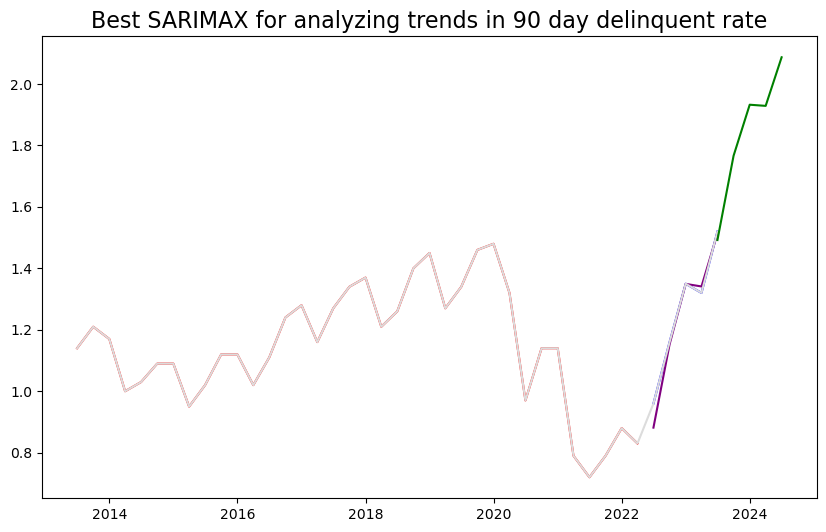

In [58]:
#Now for MAPE:
#Oooh, that really didn't take that long... likely since it was without exogenous variables. Anyways, let's see the bros:

#And gf m, messed up orders of d and q....SO JUST FOR THIS DEMO RUN will we see d and q differently...
    #Was tmpted to make a dictionary, but eh...
#[2, 2, 1, 0, 1, 2, 4].
# p = best_mape_params[0]
# d = best_mape_params[1]
# q = best_mape_params[2]
# P = best_mape_params[3]
# D = best_mape_params[4]
# Q = best_mape_params[5]
# S = best_mape_params[6]

p = 2
d = 2
q = 1
P = 0
D = 1
Q = 2
S = 4

sarima90 = SARIMAX(endog=y_train_90,
                order=(p,d,q), seasonal_order=(P, D, Q, S),
                )


# Fit SARIMA model.
model90 = sarima90.fit()
# Generate predictions based on test set.
preds90 = model90.predict(start = datetime(2022,7,1), end=datetime(2023,7,1),
                     )

print(mean_absolute_percentage_error(y_test_90, preds))

#Conversions, at least needed for this data.Thank you Eric!
y_train_notcontroversial90, y_test_notcontroversial90 = y_train_90.copy(), y_test_90.copy()
y_train_notcontroversial90.index = pd.to_datetime(y_train_notcontroversial90.index)
y_test_notcontroversial90.index = pd.to_datetime(y_test_notcontroversial90.index)

#To keep things simple, I'd like to get these guys set up here too:
sarima_tt_90 = SARIMAX(endog=y_90_tt,
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S)
                )

model_90f = sarima_tt_90.fit()

preds_90f = model_90f.predict(start = datetime(2023,7,1), end=datetime(2024,7,1),
                     )

y_tt_notcontroversial90 = y_90_tt.copy()
#y_val_notcontroversial = y_val.copy()
y_tt_notcontroversial90.index = pd.to_datetime(y_90_tt.index)
#y_val_notcontroversial.index = pd.to_datetime(y_tt_notcontroversial90.index)

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train_notcontroversial90, color = 'red')
plt.plot(y_test_notcontroversial90, color = 'blue')
plt.plot(preds90, color = 'purple')

plt.plot(y_tt_notcontroversial90, color = 'gainsboro')
plt.plot(preds_90f, color = 'green')

plt.title(label = 'Best SARIMAX for analyzing trends in 90 day delinquent rate', fontsize=16)
plt.show();

In [35]:
# #Once again them mapes... #Anyways, let's go at least 3 exog variables to try... we'll start with 90 days given that it
# #wasn't as smooth:
# #And for at least right now we'll go with mapes...
# base=X_train_fit.copy()
# approved_columns = []
# if len(approved_columns) > 0:
#     base = X_train_fit.drop(approved_columns, axis = 1)
# for col_candidate in range(len(base.columns)):
#     approved_columns.append(base.columns[col_candidate])
#     X_tuning = X_train_fit[approved_columns]
#     #code
#     approved_columns.remove(base.columns[col_candidate])

In [36]:
# #90 day times, and high hopes for MAPE:

# # Starting AIC and MAPE:
# best_aic = 100_000_000
# best_mape = 100_000_000
# best_aic_params, best_mape_params = [], []
# current_top_draft_pick = ''
# # final_p = final_d = final_q = 0
# # final_P = final_D = final_Q = final_S =0

# #base=X_train_fit.copy()
# #base_tune, base_tamp = X_train.copy(), X_test.copy()
# approved_columns = []
# base_tune = X_train.drop(approved_columns, axis = 1).copy()
# for col_candidate in range(len(base_tune.columns)):
#         approved_columns.append(base_tune.columns[col_candidate])
#         X_tuning = X_train[approved_columns]
#         X_tamperig = X_test[approved_columns]
#         X_tuning = ss.fit_transform(X_tuning)
#         X_tamperig = ss.transform(X_tamperig)
# # for i in range(0, 3):
# #     #if len(approved_columns) > 0:
# #      #   base_tune = base_tune.drop(approved_columns, axis = 1)
# #       #  base_tamp = base_tamp.drop(approved_columns, axis = 1)
# #     for col_candidate in range(len(base_tune.columns)):
# #         approved_columns.append(base_tune.columns[col_candidate])
# #         X_tuning = X_train[approved_columns]
# #         X_tamperig = X_test[approved_columns]
# #         X_tuning = ss.fit_transform(X_tuning)
# #         X_tamperig = ss.transform(X_tamperig)
#         try:
#             sarimax = auto_arima(y_train_90,
#                                  exogenous = X_tuning,
#                                  start_p=0,
#                                  start_q=0,
#                                  max_p=3,
#                                  max_q=3,
#                                  max_d=3,
#                                  seasonal=True,
#                                  start_P=0,
#                                  start_Q=0,
#                                  max_P=3,
#                                  max_Q=3,
#                                  max_D=3,
#                                  m=1, #Unsure if this should be 4.,... eh...
#                                  trace=True,
#                                  error_action='ignore',
#                                  suppress_warnings=True,
#                                  stepwise=True
            
#             )
 
#                     # Fit SARIMAX model.
#             model = sarimax.fit()

#                     # Generate predictions based on test set.
#             preds = model.predict(start=datetime(2022,7,1),
#                                       end=datetime(2023,7,1),
#                                       exog=X_tamperig)

#                     # Evaluate predictions.
                                        
#                     # Save for final report.
#             if best_aic > model.aic:
#                 best_aic = model.aic
#                 best_aic_params = [p,d,q,P,D,Q,S]
#             if best_mape > mean_absolute_percentage_error(y_test_90, preds):
#                 best_mape = mean_absolute_percentage_error(y_test_90, preds)
#                 best_mape_params = [p,d,q,P,D,Q,S]
#                 current_top_draft_pick = base_tune.columns[col_candidate]

#         except:
#             pass
#         approved_columns.remove(base_tune.columns[col_candidate])
#     approved_columns.append(base_tune.columns[col_candidate])
#     print(f"Just added {current_top_draft_pick} with our best mapes, bottom line, at {best_mape}.")
# print(f'The best model has an AIC of {best_aic} with parameters of {best_aic_params}.')
# print(f'The best model has an MAPE of {best_mape} with parameters of {best_mape_params} with the following columns for exogs: {approved_columns}.')

In [37]:
# base_tune.columns[col_candidate]

In [38]:
# preds

In [39]:
#Rough process that I think is correct:
#1 Add n rows to the original dataframe, where n is the number of periods desired to forecast, dated to the desired dates.
#2 Seperate the df into X (exogenous features) and y dates
#3 Shift x by n periods
#4 Take the last n rows of X, ie the future forecasted dates, and add them to a new df,later used for validation.
    #4.1 A similar thing should be done with Y. Per my current understanding of SARIMAX a y_validation dataframe should not
        #be needed. However, it is to them relevant the next partial step:
    #4.5 Then remove them from the dataset (also the to-be forecasted ys)
#5 Drop the null rows from X and y, ie getting rid n rows.
    #X should have just nulls in them; y should have n amounts of the target.
#6 Train test split as usual, which should have a length of 'final' - 2n where original is whatever it was oriignal + n added
    #rows via forecasting.
    #Reminder to have shuffle=False


In [40]:
# #90 day times, and high hopes for MAPE:

# # Starting AIC and MAPE:
# best_aic = 100_000_000
# best_mape = 100_000_000
# best_aic_params, best_mape_params = [], []
# current_top_draft_pick = ''
# # final_p = final_d = final_q = 0
# # final_P = final_D = final_Q = final_S =0

# P = 0
# D = 1
# Q = 2
# S = 4

# #base=X_train_fit.copy()
# #base_tune, base_tamp = X_train.copy(), X_test.copy()
# approved_columns = []
# for i in range(0, 3):
#     #if len(approved_columns) > 0:
#      #   base_tune = base_tune.drop(approved_columns, axis = 1)
#       #  base_tamp = base_tamp.drop(approved_columns, axis = 1)
#     base_tune = X_train.drop(approved_columns, axis = 1).copy()
#     for col_candidate in range(base_tune.columns):
#         approved_columns.append(base_tune.columns[col_candidate])
#         X_tuning = X_train[approved_columns]
#         X_tamperig = X_test[approved_columns]
#         X_tuning = ss.fit_transform(X_tuning)
#         X_tamperig = ss.transform(X_tamperig)
#         for p in range(3):
#             for d in range(3):
#                 for q in range(3):
#                                     try:
#                                 #print(f'Attempting to fit SARIMAX({p}, {d}, {q})x({P},{D},{Q},{S})')
#                     # Instantiate SARIMAX model.
#                                         if col_candidate%10==0:
#                                             print(f"Working with {base_tune.columns[col_candidate]}:")
#                                         sarimax = SARIMAX(endog = y_train_90,
#                                              order = (p, d, q),              # (p, d, q)
#                                              seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
#                                              exog=X_tuning) 
 
#                     # Fit SARIMAX model.
#                                         model = sarimax.fit()

#                     # Generate predictions based on test set.
#                                         preds = model.predict(start=datetime(2022,7,1),
#                                               end=datetime(2023,7,1),
#                                               exog=X_tamperig)

#                     # Evaluate predictions.
                                        
#                     # Save for final report.
#                                         if best_aic > model.aic:
#                                             best_aic = model.aic
#                                             best_aic_params = [p,d,q,P,D,Q,S]
#                                         if best_mape > mean_absolute_percentage_error(y_test_90, preds):
#                                             best_mape = mean_absolute_percentage_error(y_test_90, preds)
#                                             best_mape_params = [p,d,q,P,D,Q,S]
#                                             current_top_draft_pick = base_tune.columns[col_candidate]

#                                     except:
#                                         pass
#         approved_columns.remove(base_tune.columns[col_candidate])
#     approved_columns.append(base_tune.columns[col_candidate])
#     print(f"Just added {current_top_draft_pick} with our best mapes, bottom line, at {best_mape}.")
# print(f'The best model has an AIC of {best_aic} with parameters of {best_aic_params}.')
# print(f'The best model has an MAPE of {best_mape} with parameters of {best_mape_params} with the following columns for exogs: {approved_columns}.')

In [41]:
sarimax = SARIMAX(endog = y_train_90,
                  order = (1, 2, 1),              # (p, d, q)
                  seasonal_order = (0, 1, 2, 4)  # (P, D, Q, S)
                  #exog=X_train[X_train.columns[0]]
                  ) 
 
                    # Fit SARIMAX model.
model = sarimax.fit()

                    # Generate predictions based on test set.
preds = model.predict(start=datetime(2022,7,1),
        end=datetime(2023,7,1)
        #exog=X_test[X_test.columns[0]]
        )

                    # Evaluate predictions.
                                        
mean_absolute_percentage_error(y_test_90, preds)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


0.5980192877928558

In [42]:
y_test_90

date
2022-07-01    0.96
2022-10-01    1.16
2023-01-01    1.35
2023-04-01    1.32
2023-07-01    1.52
Name: cc_bals_90d_due_percentage, dtype: float64

In [43]:
print(len(X_train.columns))
approved_columns = []
base_tune = X_train.drop(approved_columns, axis = 1).copy()
base_tune.shape

51


(36, 51)

In [52]:
# #To attempt to make things easier, I'll re-do all the fittings here:
# p = 0
# d = 2
# q = 2
# P = 0
# D = 1
# Q = 2
# S = 4

# sarima_30 = SARIMAX(endog=y_train_30,
#                 order=(p,d,q), 
#                 seasonal_order=(P, D, Q, S)
#                 )
# model_30 = sarima_30.fit()
# preds_30 = model_30.predict(start = datetime(2022,7,1), end=datetime(2023,7,1))
# print(f"{mean_absolute_percentage_error(y_test_30, preds_30)} is the 30 day MAPE.")

# #Conversions, at least needed for this data.Thank you Eric!
# y_train_nc_30, y_test_nc_30 = y_train_30.copy(), y_test_30.copy() #nc = not controversial
# y_train_nc_30.index = pd.to_datetime(y_train_nc_30.index)
# y_test_nc_30.index = pd.to_datetime(y_test_nc_30.index)

# #Refitting everything time (30):
# sarima_tt_30 = SARIMAX(endog=y_30_tt,
#                 order=(p,d,q), 
#                 seasonal_order=(P, D, Q, S)
#                 )
# model_30f = sarima_tt_30.fit()
# preds_30f = model_30f.predict(start = datetime(2023,7,1), end=datetime(2024,7,1))

# y_tt_nc_30 = y_30_tt.copy()
# y_tt_nc_30.index = pd.to_datetime(y_tt_nc_30.index)

# #Transitioning now to the 90 day delinquent rate:
# p = 2
# d = 2
# q = 1
# P = 0
# D = 1
# Q = 2
# S = 4

# sarima_90 = SARIMAX(endog=y_train_90,
#                 order=(p,d,q), seasonal_order=(P, D, Q, S))
# model_90 = sarima_90.fit()
# preds_90 = model_90.predict(start = datetime(2022,7,1), end=datetime(2023,7,1))
# print(f"{mean_absolute_percentage_error(y_test_90, preds_90)} is the 90 day MAPE.")

# y_train_nc_90, y_test_nc_90 = y_train_90.copy(), y_test_90.copy()
# y_train_nc_90.index = pd.to_datetime(y_train_nc_90.index)
# y_test_nc_90.index = pd.to_datetime(y_test_nc_90.index)

# #And, time for the final valuation:
# sarima_tt_90 = SARIMAX(endog=y_90_tt,
#                 order=(p,d,q), 
#                 seasonal_order=(P, D, Q, S)
#                 )
# model_90f = sarima_tt_90.fit()
# preds_90f = model_90f.predict(start = datetime(2023,7,1), end=datetime(2024,7,1))

# y_tt_nc_90 = y_90_tt.copy()
# y_tt_nc_90.index = pd.to_datetime(y_tt_nc_90.index)

# preds_30.index = pd.to_datetime(preds_30.index)
# preds_30f.index = pd.to_datetime(preds_30f.index)
# preds_90.index = pd.to_datetime(preds_90.index)
# preds_90f.index = pd.to_datetime(preds_90f.index)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was prov

0.0139128423957972 is the 30 day MAPE.
0.02179867039893528 is the 90 day MAPE.


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


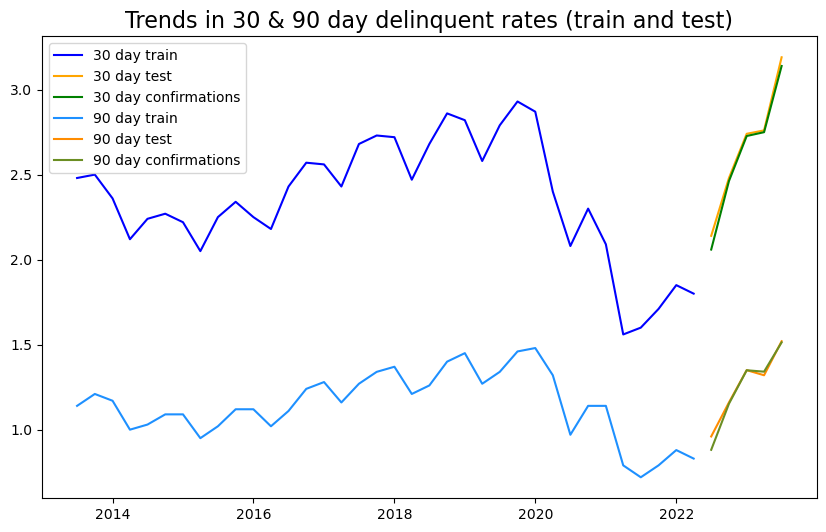

In [89]:
#We'll do both the original tests on here
plt.figure(figsize=(10,6))

plt.plot(y_train_notcontroversial, color = 'blue', label='30 day train')
plt.plot(y_test_notcontroversial, color = 'orange', label='30 day test')
plt.plot(preds, color = 'green', label='30 day confirmations')

plt.plot(y_train_notcontroversial90, color = 'dodgerblue', label='90 day train')
plt.plot(y_test_notcontroversial90, color = 'darkorange', label='90 day test')
plt.plot(preds90, color = 'olivedrab', label='90 day confirmations')

plt.title(label = 'Trends in 30 & 90 day delinquent rates (train and test)', fontsize=16)
plt.legend()
plt.show();

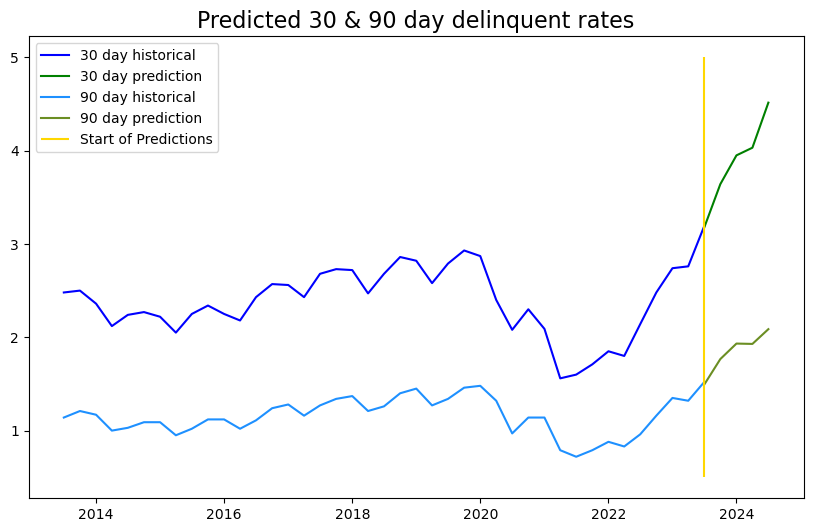

In [90]:
#Now for the 'val'data ie future predictions
plt.figure(figsize=(10,6))

plt.plot(y_tt_notcontroversial_30, color = 'blue', label='30 day historical')
plt.plot(preds_30f, color = 'green', label='30 day prediction')

plt.plot(y_tt_notcontroversial90, color = 'dodgerblue', label='90 day historical')
plt.plot(preds_90f, color = 'olivedrab', label='90 day prediction')

plt.vlines(x = '2023-07-01', ymin=.5, ymax=5.0, color = 'gold', label='Start of Predictions')

plt.title(label = 'Predicted 30 & 90 day delinquent rates', fontsize=16)
plt.legend()
plt.show();

In [91]:
# y_train_90

In [96]:
preds_30f #Note, if I didn't write it already, that the first one is superfluous, and technically lower than the real one... but
#for the sake of the visiaul I didn't change it.

2023-07-01    3.174775
2023-10-01    3.640551
2024-01-01    3.949101
2024-04-01    4.031101
2024-07-01    4.513997
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [87]:
preds_90f

2023-07-01    1.492264
2023-10-01    1.766480
2024-01-01    1.932600
2024-04-01    1.928836
2024-07-01    2.087010
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [102]:
delinq_predictions = pd.DataFrame(data={'30d_preds':preds_30f, '90d_preds':preds_90f})
delinq_predictions

,30d_preds,90d_preds
2023-07-01,3.174775,1.492264
2023-10-01,3.640551,1.766480
2024-01-01,3.949101,1.932600
2024-04-01,4.031101,1.928836
2024-07-01,4.513997,2.087010


In [103]:
# delinq_predictions.to_csv('../data/delinquency_predictions_sarimax.csv', index=True)

In [104]:
delinq_predictions = pd.read_csv('../data/delinquency_predictions_sarimax.csv')
delinq_predictions

,Unnamed: 0,30d_preds,90d_preds
0,2023-07-01,3.174775,1.492264
1,2023-10-01,3.640551,1.766480
2,2024-01-01,3.949101,1.932600
3,2024-04-01,4.031101,1.928836
4,2024-07-01,4.513997,2.087010
